In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade xgboost==1.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1


In [20]:
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import ast
from scipy.sparse import hstack


In [21]:
import os
os.getcwd()

'/Users/utkarshmaheshwari/Desktop/Personal Project_GT/02_NutriLens/NutriLens-clean/notebooks'

In [22]:
path_to_file = "/content/drive/MyDrive/only_english.csv"
path_to_file = "../data/analysis_data/only_english.csv"
data = pd.read_csv(path_to_file, low_memory=False)
data.head()

,code,product_name,categories_tags,ingredients_text,ingredient_count,additives_n,additive_density,nutriscore_score,monounsaturated-fat_100g,sugars_100g,polyunsaturated-fat_100g,sugar_fiber_ratio,carbohydrates_100g,fiber_100g,saturated-fat_100g,sodium_per_calorie,allergens_en,nova_group
0,00000028,Hershey’s Syrup,"en:beverages-and-beverages-preparations,en:bev...",organ defat hemp seed powder certifi organ qua...,1,0.0,0.000000,NaN,0.0,6.0,0.0,0.594059,15.00,10.000,0.0,NaN,NaN,1
1,00000116,Vanille-Erdbeer-Cocktail,NaN,sunflow seed butter roast sunflow kernel dri c...,30,4.0,0.129032,NaN,0.0,0.0,0.0,NaN,8.82,0.441,0.0,NaN,NaN,4
2,00000226,Naturelo,NaN,methylcellulos color preserv flavong ount per ...,5,1.0,0.166667,NaN,0.0,0.0,0.0,NaN,0.00,0.000,0.0,NaN,NaN,4
3,00000261,Prebiotic Fiber Gummies,"en:snacks,en:sweet-snacks,en:confectioneries,e...",chicori root fiber water pectin agar agar tapi...,11,6.0,0.500000,NaN,0.0,0.0,0.0,NaN,0.00,0.000,0.0,NaN,NaN,4
4,00000283,Irish Sea Moss,NaN,irish sea moss extract chondru crispu hypromel...,3,2.0,0.500000,NaN,0.0,0.0,0.0,NaN,0.00,0.000,0.0,NaN,NaN,4


In [23]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
text_cols = data.select_dtypes(include=['object']).columns

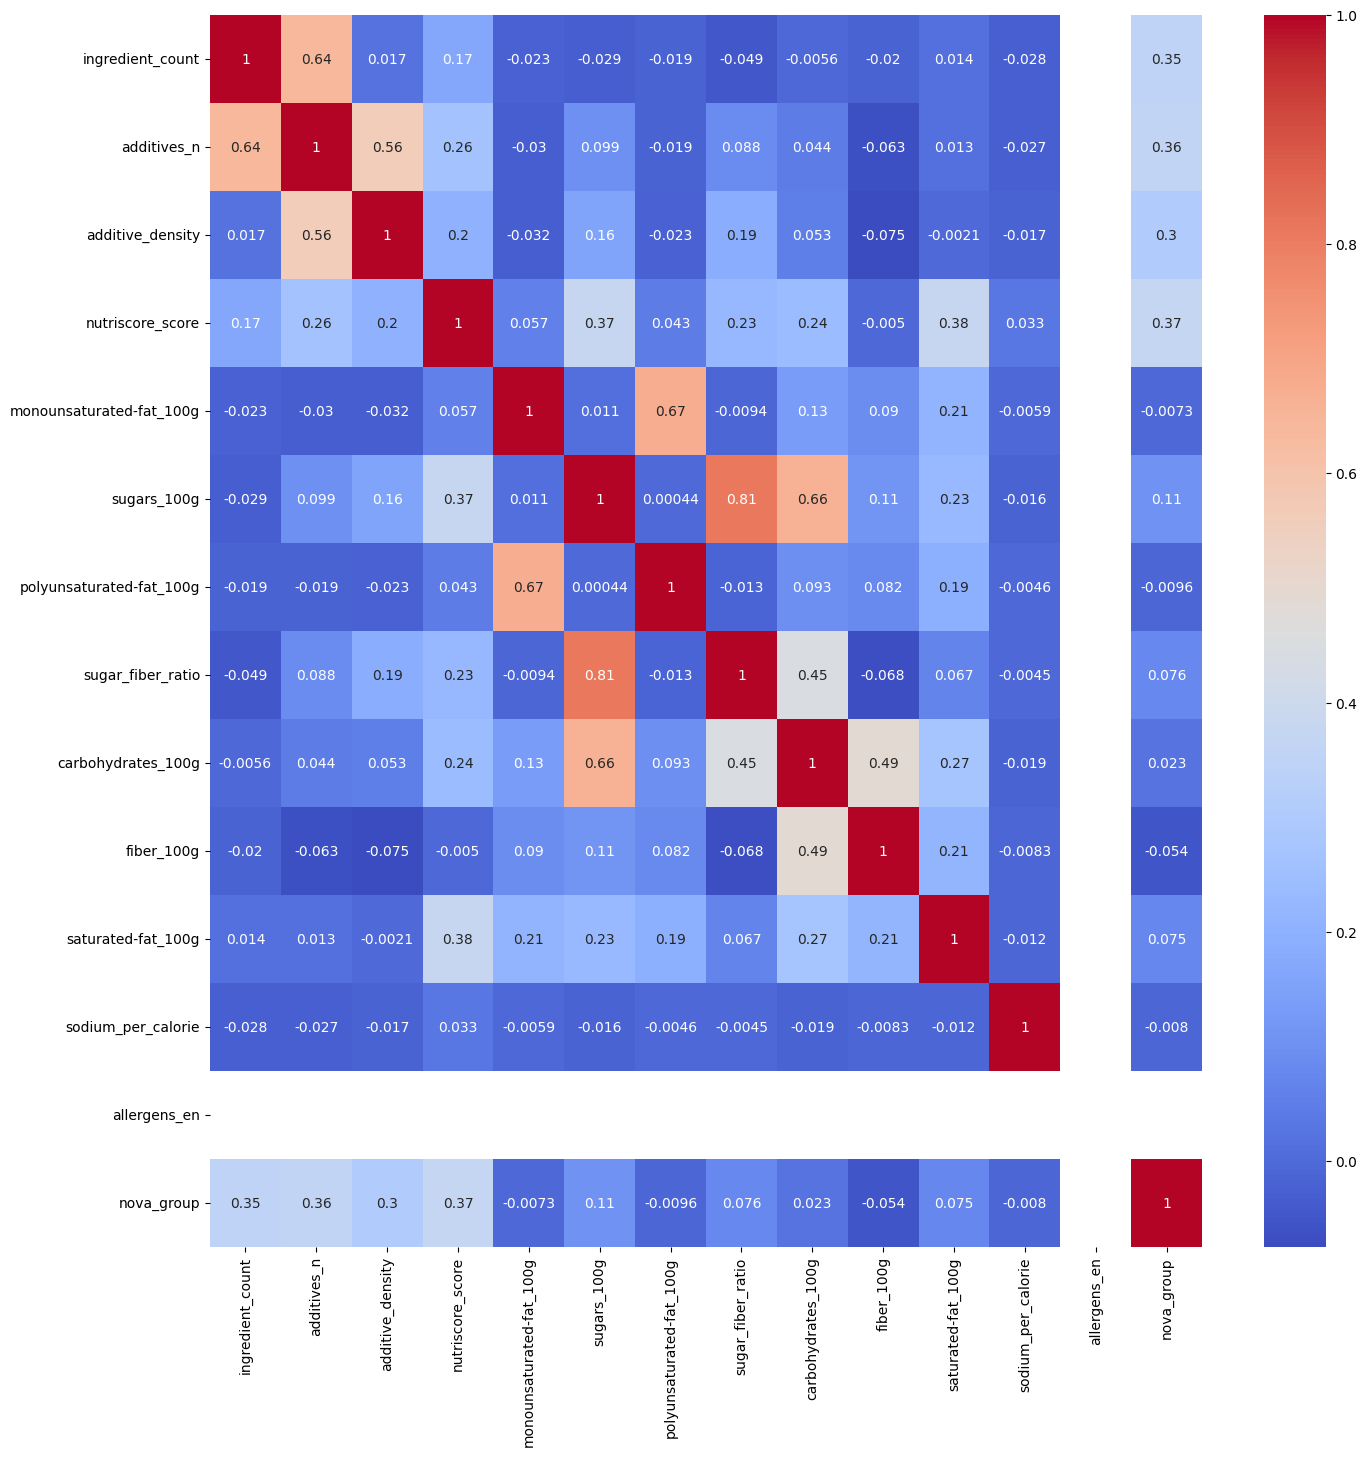

In [24]:
corr = data[numeric_cols].corr(method='pearson')
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [25]:
print(len(data['product_name'].unique()))

195519


In [26]:
data['categories_tags'] = data['categories_tags'].fillna('')
data['categories_tags'] = data['categories_tags'].apply(lambda x: x.split(',') if x else [])

In [27]:
path = "/content/drive/MyDrive/embeddings/embeddings.npy"
path = "../data/analysis_data/embeddings.npy"
embeddings = np.load(path)
embeddings.shape

(272809, 384)

In [28]:
numeric_cols_m = ['ingredient_count', 'additives_n', 'additive_density','nutriscore_score', 'monounsaturated-fat_100g', 'sugars_100g',
       'polyunsaturated-fat_100g', 'sugar_fiber_ratio', 'carbohydrates_100g',
       'fiber_100g', 'saturated-fat_100g', 'sodium_per_calorie',
       'allergens_en']

X_numeric = data[numeric_cols_m].values.astype(np.float32)
y = data['nova_group'] - 1

# only embeddings + numeric
X_basic = np.hstack([embeddings, X_numeric])

X_train_basic, X_test_basic, y_train, y_test, train_idx, test_idx = train_test_split(
    X_basic, y, np.arange(len(y)), test_size=0.2, random_state=42, stratify=y
)

In [29]:
# Fit TF-IDF
tfidf = TfidfVectorizer(max_features=200, ngram_range=(1,2))
tfidf_train = tfidf.fit_transform(data.loc[train_idx, 'product_name'].fillna(''))
tfidf_test = tfidf.transform(data.loc[test_idx, 'product_name'].fillna(''))

# Fit PCA
pca_tfidf = PCA(n_components=10)
pca_tfidf_train = pca_tfidf.fit_transform(tfidf_train.toarray())
pca_tfidf_test = pca_tfidf.transform(tfidf_test.toarray())

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD

# Multilabel binarizer (sparse)
mlb_cat = MultiLabelBinarizer(sparse_output=True)

cats_train = mlb_cat.fit_transform(data.loc[train_idx, 'categories_tags'])
cats_test = mlb_cat.transform(data.loc[test_idx, 'categories_tags'])

# Truncated SVD
svd_cats = TruncatedSVD(n_components=5, random_state=42)

svd_cats_train = svd_cats.fit_transform(cats_train)
svd_cats_test = svd_cats.transform(cats_test)

# concatenate features
X_train = np.hstack([
    X_train_basic,
    pca_tfidf_train.astype(np.float32),
    svd_cats_train.astype(np.float32)
])

X_test = np.hstack([
    X_test_basic,
    pca_tfidf_test.astype(np.float32),
    svd_cats_test.astype(np.float32)
])


/Users/utkarshmaheshwari/opt/anaconda3/envs/nutrilens/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['de:apfelstangen', 'de:stangen', 'en:0', 'en:100-arena-integral', 'en:100-natural-vanilla-extract', 'en:100-whey-protein-milkshake', 'en:60', 'en:abalone', 'en:abbey-ales', 'en:all', 'en:all-purpose-flour-mix', 'en:all-purpose-sauce', 'en:almond-butter-pretzels', 'en:almond-flour-tortilla', 'en:almondmilk', 'en:amaretti', 'en:antacid', 'en:anti-aging-serum', 'en:aoc-cheeses', 'en:apple-chips', 'en:apple-sauce-in-pouch', 'en:apple-soft-drinks', 'en:apples-with-caramel', 'en:arame-seaweeds', 'en:artificial-flavor', 'en:baby-care-product', 'en:baby-cologne', 'en:baby-follow-on-milk-from-5-months', 'en:baby-milks-in-powder', 'en:baby-skin-care', 'en:bacon-and-potato-bowl', 'en:bagel-chips', 'en:baked-pita-chips', 'en:balanced-nutritional-drink', 'en:barley-based-drinks', 'en:barn-chicken-eggs', 'en:bath-salt', 'en:bean-salad', 'en:bean-verm

In [ ]:
# Fit multilabel binarizer
mlb_cat = MultiLabelBinarizer()
cats_train = mlb_cat.fit_transform(data.loc[train_idx, 'categories_tags'])
cats_test = mlb_cat.transform(data.loc[test_idx, 'categories_tags'])

# Fit PCA
pca_cats = PCA(n_components=5)
pca_cats_train = pca_cats.fit_transform(cats_train)
pca_cats_test = pca_cats.transform(cats_test)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['de:apfelstangen', 'de:stangen', 'en:0', 'en:100-arena-integral', 'en:100-natural-vanilla-extract', 'en:100-whey-protein-milkshake', 'en:60', 'en:abalone', 'en:abbey-ales', 'en:all', 'en:all-purpose-flour-mix', 'en:all-purpose-sauce', 'en:almond-butter-pretzels', 'en:almond-flour-tortilla', 'en:almondmilk', 'en:amaretti', 'en:antacid', 'en:anti-aging-serum', 'en:aoc-cheeses', 'en:apple-chips', 'en:apple-sauce-in-pouch', 'en:apple-soft-drinks', 'en:apples-with-caramel', 'en:arame-seaweeds', 'en:artificial-flavor', 'en:baby-care-product', 'en:baby-cologne', 'en:baby-follow-on-milk-from-5-months', 'en:baby-milks-in-powder', 'en:baby-skin-care', 'en:bacon-and-potato-bowl', 'en:bagel-chips', 'en:baked-pita-chips', 'en:balanced-nutritional-drink', 'en:barley-based-drinks', 'en:barn-chicken-eggs', 'en:bath-salt', 'en:bean-salad', 'en:bean-vermicelli', 'en:beef-stew-with-vegetables', 'e

In [16]:
# concatenate features
X_train = np.hstack([X_train_basic, pca_tfidf_train.astype(np.float32), pca_cats_train.astype(np.float32)])
X_test = np.hstack([X_test_basic, pca_tfidf_test.astype(np.float32), pca_cats_test.astype(np.float32)])

NameError: name 'pca_cats_train' is not defined

In [31]:
model_rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, verbose=1)
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


              precision    recall  f1-score   support

           0       0.96      0.89      0.93      3233
           1       0.94      0.64      0.76       347
           2       0.91      0.79      0.84      8178
           3       0.96      0.99      0.97     42804

    accuracy                           0.95     54562
   macro avg       0.94      0.83      0.88     54562
weighted avg       0.95      0.95      0.95     54562



[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.0s finished


In [32]:
# embeddings
emb_columns = [f"emb_{i}" for i in range(embeddings.shape[1])]

# PCA for TF-IDF
pca_tfidf_columns = [f"pca_tfidf_{i}" for i in range(pca_tfidf_train.shape[1])]

# PCA for category tags
pca_cats_columns = [f"pca_cats_{i}" for i in range(pca_cats_train.shape[1])]

# Numeric columns
numeric_columns = numeric_cols_m  # your original numeric columns list

# Combine all
all_columns = emb_columns + pca_tfidf_columns + pca_cats_columns + numeric_columns

NameError: name 'pca_cats_train' is not defined

In [16]:
importances = model_rf.feature_importances_

top_indices = np.argsort(importances)[::-1][:40]

for i in top_indices:
    print(all_columns[i], '\t',importances[i])

pca_tfidf_2 	 0.05389478000897237
pca_tfidf_1 	 0.05040043302859995
emb_319 	 0.029400692295945205
pca_tfidf_0 	 0.024371216453897535
emb_223 	 0.023908726067811234
emb_332 	 0.021571556980275342
emb_127 	 0.017835101427821534
emb_122 	 0.01651888415994861
emb_20 	 0.012659225722580096
emb_309 	 0.010747694696383491
emb_109 	 0.010199628583129021
emb_239 	 0.008963141583783857
emb_16 	 0.008809498609217349
emb_372 	 0.008533587210823777
pca_tfidf_3 	 0.007968941359112188
emb_256 	 0.006756458056318903
emb_255 	 0.006159163235944637
pca_cats_1 	 0.006136770018616736
emb_365 	 0.0060520883737290275
emb_115 	 0.0058987764555812885
emb_172 	 0.005887883991917963
emb_141 	 0.005818401553866471
carbohydrates_100g 	 0.005689486463891091
emb_265 	 0.0053647784943950125
emb_83 	 0.005347194181920325
emb_289 	 0.0050812447813840264
emb_351 	 0.004823871278159498
emb_241 	 0.0047554382043938845
emb_23 	 0.004640756436649698
emb_46 	 0.004411067009666725
emb_70 	 0.004177052870186073
emb_270 	 0.0

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

model_xgb = xgb.XGBClassifier(
    n_estimators=500, max_depth=7, learning_rate=0.1, eval_metric='mlogloss', tree_method='gpu_hist'
)
model_xgb.fit(X_train, y_train,  eval_set=[(X_train, y_train_enc), (X_test, y_test_enc)])

[0]	validation_0-mlogloss:1.23068	validation_1-mlogloss:1.23191
[1]	validation_0-mlogloss:1.10382	validation_1-mlogloss:1.10621
[2]	validation_0-mlogloss:0.99816	validation_1-mlogloss:1.00179
[3]	validation_0-mlogloss:0.90770	validation_1-mlogloss:0.91224
[4]	validation_0-mlogloss:0.82992	validation_1-mlogloss:0.83539
[5]	validation_0-mlogloss:0.76233	validation_1-mlogloss:0.76854
[6]	validation_0-mlogloss:0.70290	validation_1-mlogloss:0.70983
[7]	validation_0-mlogloss:0.65027	validation_1-mlogloss:0.65801
[8]	validation_0-mlogloss:0.60353	validation_1-mlogloss:0.61211
[9]	validation_0-mlogloss:0.56192	validation_1-mlogloss:0.57126
[10]	validation_0-mlogloss:0.52458	validation_1-mlogloss:0.53454
[11]	validation_0-mlogloss:0.49126	validation_1-mlogloss:0.50162
[12]	validation_0-mlogloss:0.46101	validation_1-mlogloss:0.47224
[13]	validation_0-mlogloss:0.43394	validation_1-mlogloss:0.44585
[14]	validation_0-mlogloss:0.40935	validation_1-mlogloss:0.42187
[15]	validation_0-mlogloss:0.38681	

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [18]:
y_pred = model_xgb.predict(X_test)
y_pred+=1
y_test+=1

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.94      0.95      3233
           2       0.95      0.85      0.90       347
           3       0.91      0.90      0.91      8178
           4       0.98      0.99      0.98     42804

    accuracy                           0.97     54562
   macro avg       0.95      0.92      0.94     54562
weighted avg       0.97      0.97      0.97     54562



In [19]:
importances = model_xgb.feature_importances_

top_indices = np.argsort(importances)[::-1][:40]

for i in top_indices:
    print(all_columns[i], '\t',importances[i])


pca_tfidf_1 	 0.14983095
pca_tfidf_0 	 0.042947974
emb_256 	 0.02072232
emb_20 	 0.019837884
emb_162 	 0.019599859
emb_309 	 0.016816648
emb_122 	 0.016700502
emb_332 	 0.016190255
emb_351 	 0.013853287
emb_319 	 0.013360286
emb_223 	 0.01131373
emb_172 	 0.009848826
emb_352 	 0.007805732
pca_tfidf_3 	 0.0073658787
emb_119 	 0.007189153
emb_372 	 0.0070191543
emb_288 	 0.006970465
pca_cats_1 	 0.0068871332
carbohydrates_100g 	 0.006548848
emb_265 	 0.0060575795
emb_109 	 0.005725608
emb_224 	 0.004979057
emb_1 	 0.004943436
emb_46 	 0.0046179504
emb_57 	 0.0046053804
pca_tfidf_4 	 0.004504534
emb_344 	 0.0044296975
emb_147 	 0.0042899363
emb_140 	 0.0041475818
emb_130 	 0.0041269697
emb_108 	 0.0041057733
emb_376 	 0.004049768
emb_8 	 0.003908985
emb_367 	 0.00381371
emb_85 	 0.0036382454
emb_155 	 0.003635398
emb_111 	 0.0036192778
emb_254 	 0.0035200103
saturated-fat_100g 	 0.003469381
emb_267 	 0.0034380537
